<a href="https://colab.research.google.com/github/Bagito999/Deep-Learning/blob/main/Deep_Learning_Infrared_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
data_path = '/content/drive/MyDrive/Deep Learning/Infrared.csv'
df = pd.read_csv(data_path)

# Handle missing values
df = df.dropna(subset=['Distance'])

# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=['Gender', 'Age', 'Ethnicity'], drop_first=True)

# Split features and target
X = df.drop(columns=['aveOralM'])
y = df['aveOralM'].values.reshape(-1, 1)

In [ ]:
# Standardize numerical features
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

# Normalize target variable
y_scaler = StandardScaler()
y_scaled = y_scaler.fit_transform(y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Convert to numpy arrays
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)

In [ ]:
class DeepModelTorch(nn.Module):
    def __init__(self, input_dim):  # Corrected __init__ method
        super(DeepModelTorch, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),   # W*x + b
            nn.ReLU(),                  # max(0, x)
            nn.BatchNorm1d(64),         # (x - batch_mean) / (batch_std + epsilon)
            nn.Dropout(0.2),            # Each neuron has 0.2 probability of being zeroed
            nn.Linear(64, 32),          # W*x + b
            nn.ReLU(),                  # max(0, x)
            nn.Linear(32, 1)            # Final output layer
        )

    def forward(self, x):
        return self.model(x)

In [ ]:
# Initialize PyTorch model
input_dim = X_train.shape[1]
model_torch = DeepModelTorch(input_dim)
criterion = nn.MSELoss()  # Implements MSE equation
optimizer = optim.Adam(model_torch.parameters(), lr=0.0001)

# Convert data to PyTorch tensors
X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
# Training history tracking
torch_losses = []

# Train PyTorch model
for epoch in range(100):
    model_torch.train()  # Set model to training mode
    optimizer.zero_grad()  # Reset gradients

    # Forward pass
    outputs = model_torch(X_train_torch)

    # Calculate loss
    loss = criterion(outputs, y_train_torch)

    # Backward pass (computes ∇θJ(θ))
    loss.backward()

    # Update weights (θ = θ - α * ∇θJ(θ))
    optimizer.step()

    torch_losses.append(loss.item())
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

print("PyTorch model training complete!")

# Predict with PyTorch model
model_torch.eval()  # Set model to evaluation mode
with torch.no_grad():
    y_pred_torch = model_torch(X_test_torch).numpy()

    # Inverse transform to get original scale
    y_test_original = y_scaler.inverse_transform(y_test)
    y_pred_torch_original = y_scaler.inverse_transform(y_pred_torch)

Epoch 0, Loss: 1.3078923225402832
Epoch 10, Loss: 1.2219634056091309
Epoch 20, Loss: 1.12065851688385
Epoch 30, Loss: 1.0613164901733398
Epoch 40, Loss: 0.9894053936004639
Epoch 50, Loss: 0.9488880634307861
Epoch 60, Loss: 0.8749621510505676
Epoch 70, Loss: 0.8110213875770569
Epoch 80, Loss: 0.7669031620025635
Epoch 90, Loss: 0.7009671926498413
PyTorch model training complete!


In [ ]:
# TensorFlow Model
model_tf = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    layers.BatchNormalization(),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

# Compile TensorFlow model
model_tf.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mse', metrics=['mse'])

# Train TensorFlow model
history = model_tf.fit(
    X_train, y_train,
    epochs=100,
    verbose=1,
    batch_size=32,
    validation_split=0.1
)

# Predict with TensorFlow model
y_pred_tf = model_tf.predict(X_test)
y_pred_tf_original = y_scaler.inverse_transform(y_pred_tf)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 4.6013 - mse: 4.6013 - val_loss: 1.3859 - val_mse: 1.3859
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9965 - mse: 2.9965 - val_loss: 1.1325 - val_mse: 1.1325
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.8300 - mse: 2.8300 - val_loss: 0.9320 - val_mse: 0.9320
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4422 - mse: 2.4422 - val_loss: 0.7848 - val_mse: 0.7848
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7744 - mse: 1.7744 - val_loss: 0.6884 - val_mse: 0.6884
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3469 - mse: 1.3469 - val_loss: 0.6266 - val_mse: 0.6266
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2883 - mse: 1.2883 - val_loss: 0.5839 - val_mse: 0.5839
Epoch 8/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2285 - mse: 1.2285 - val_loss: 0.5690 - val_mse: 0.5690
Epoch 9/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9738 - mse: 0.

In [ ]:
def evaluate_model(y_true, y_pred, model_name):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()

    # Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # R-squared (coefficient of determination)
    r2 = r2_score(y_true, y_pred)

    print(f"{model_name} Evaluation:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R-Squared: {r2:.4f}\n")

In [ ]:
def plot_regression_results(y_true, y_pred_torch, y_pred_tf):
    plt.figure(figsize=(12, 5))

    # Scatter plot untuk PyTorch model
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred_torch, alpha=0.5, color='blue', label='Prediksi PyTorch')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red', label='Garis Ideal')
    plt.xlabel('Nilai Sebenarnya')
    plt.ylabel('Prediksi')
    plt.title('Regresi dengan PyTorch')
    plt.legend()

    # Scatter plot untuk TensorFlow model
    plt.subplot(1, 2, 2)
    plt.scatter(y_true, y_pred_tf, alpha=0.5, color='green', label='Prediksi TensorFlow')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle='--', color='red', label='Garis Ideal')
    plt.xlabel('Nilai Sebenarnya')
    plt.ylabel('Prediksi')
    plt.title('Regresi dengan TensorFlow')
    plt.legend()

    plt.tight_layout()
    plt.show()

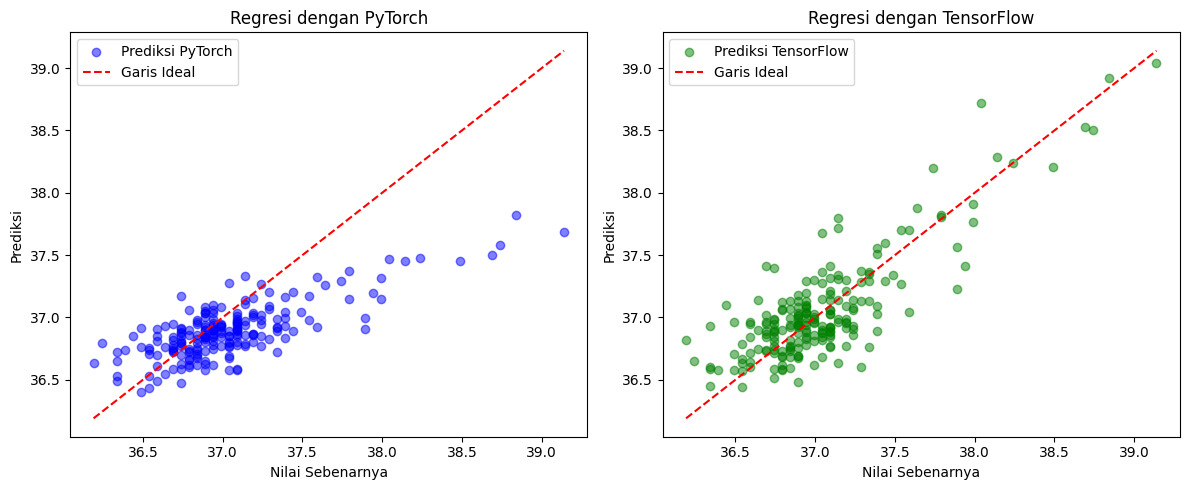

PyTorch Model Evaluation:
MSE: 0.1156
RMSE: 0.3400
R-Squared: 0.4188

TensorFlow Model Evaluation:
MSE: 0.0657
RMSE: 0.2563
R-Squared: 0.6697



In [ ]:
# Panggil fungsi untuk menampilkan grafik
plot_regression_results(y_test_original, y_pred_torch_original, y_pred_tf_original)

# Evaluate both models
torch_metrics = evaluate_model(y_test_original, y_pred_torch_original, "PyTorch Model")
tf_metrics = evaluate_model(y_test_original, y_pred_tf_original, "TensorFlow Model")

# 📌 Evaluasi Model: RMSE, MSE, dan R-Squared  



---

##  1. Mean Squared Error (MSE)  
Mean Squared Error (MSE) mengukur rata-rata dari kuadrat selisih antara nilai aktual (\($y_i$\)) dan nilai prediksi ($(\hat{y}_i)$).  

\[
$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$
\]

- **Semakin kecil nilai MSE, semakin baik modelnya.**  
- MSE peka terhadap outlier karena menggunakan selisih kuadrat.  

---

##  2. Root Mean Squared Error (RMSE)  
Root Mean Squared Error (RMSE) adalah akar kuadrat dari MSE. Metrik ini memiliki satuan yang sama dengan data asli sehingga lebih mudah diinterpretasikan.  

\[
$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$
\]

- **Semakin kecil RMSE, semakin baik performa model.**  
- RMSE lebih cocok untuk membandingkan kesalahan model dalam skala yang sama dengan data asli.  

---

##  3. R-Squared (R²) - Koefisien Determinasi  
R-Squared (\($R^2$\)) mengukur seberapa baik model menjelaskan variabilitas dalam data. Nilai \($R^2$\) berkisar antara 0 hingga 1.  

\[
$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$
\]

- Jika \( $R^2 = 1 $\), model menjelaskan semua variasi data dengan sempurna.  
- Jika \( $R^2 = 0 $\), model tidak lebih baik daripada rata-rata sebagai prediksi.  
- Nilai negatif \($R^2$\) menunjukkan model lebih buruk daripada rata-rata.  

---

## 📌 Kesimpulan  
- **MSE dan RMSE** digunakan untuk mengukur seberapa besar kesalahan prediksi model dalam satuan kuadrat atau asli.  
- **R-Squared (\($R^2$\))** digunakan untuk mengetahui seberapa baik model menjelaskan variasi dalam data.  
- **Pemilihan metrik tergantung pada kebutuhan:**  
  - Jika ingin menilai **kesalahan absolut**, gunakan **RMSE**.  
  - Jika ingin melihat **kemampuan model menjelaskan data**, gunakan **\($R^2$\)**.  
